In [1]:
import numpy as np
import pandas as pd 
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold, learning_curve
from sklearn.model_selection import learning_curve
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import optuna
%matplotlib inline
import random
import sys
        
!pip install transformers
import torch
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel
import unicodedata
from transformers import AdamW, AutoModelForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
from torch import nn

!python -m spacy download el_core_news_sm
import spacy

# !pip install greek-stemmer-pos
# from greek_stemmer import stemmer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 48.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')
/kaggle/input/ys19-2023-assignment-4a/sample_submission.csv
/kaggle/input/ys19-2023-assignment-4a/test_set.csv
/kaggle/input/ys19-2023-assignment-4a/valid_set.csv
/kaggle/input/ys19-2023-assignment-4a/train_set.csv


In [2]:
def plot_loss_curve(loss_values):
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()
    
def plot_confusion_matrix(y_true, predicted, class_names):
    cm = confusion_matrix(y_true, predicted)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

In [3]:
# Load the dataset
df = pd.read_csv("../input/ys19-2023-assignment-4a/train_set.csv").head(800)     # REDUCED TO SUBMIT 
df_valid_csv = pd.read_csv("../input/ys19-2023-assignment-4a/valid_set.csv").head(800)
df_test_csv = pd.read_csv("../input/ys19-2023-assignment-4a/test_set.csv").head(800)

train_texts, test_texts, train_labels, test_labels = train_test_split(df['Text'], df['Sentiment'], test_size=0.2)

tokenizer = BertTokenizer.from_pretrained('nlpaueb/bert-base-greek-uncased-v1')
# tokenizer = BertTokenizer.from_pretrained('EftychiaKarav/DistilGREEK-BERT')

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [4]:
from torch.utils.data import DataLoader, TensorDataset

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_labels)
y_valid_encoded = label_encoder.transform(df_valid_csv['Sentiment'])

assert (label_encoder.transform(label_encoder.classes_) == np.unique(y_encoded)).all(), "Label encoding mismatch"

train_input_ids = torch.tensor(train_encodings['input_ids'])
train_attention_masks = torch.tensor(train_encodings['attention_mask'])
train_labels_tensor = torch.tensor(y_encoded)

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-03-12 20:32:42,872] A new study created in memory with name: no-name-33a77d25-0669-4dd6-b8a5-2f0e6f8d5c30
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyT

Epoch 1: Loss = 1.13367
Epoch 2: Loss = 1.07561
Epoch 3: Loss = 1.02006
Validation Accuracy: 0.671875


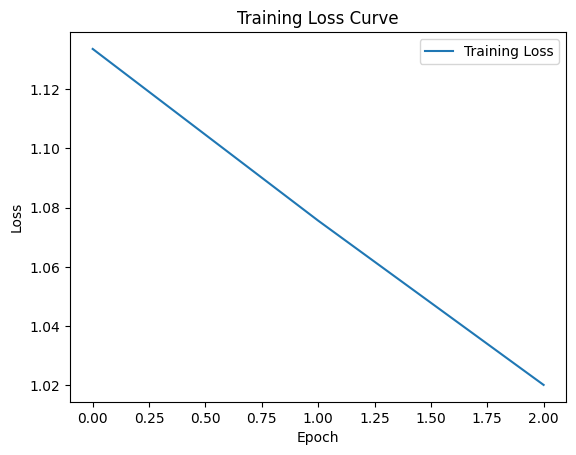

[I 2024-03-12 20:51:04,297] Trial 0 finished with value: 0.671875 and parameters: {'learning_rate': 2.026573506729358e-05, 'batch_size': 16}. Best is trial 0 with value: 0.671875.


Epoch 1: Loss = 0.96305
Epoch 2: Loss = 0.72355
Epoch 3: Loss = 0.49734
Validation Accuracy: 0.9703125


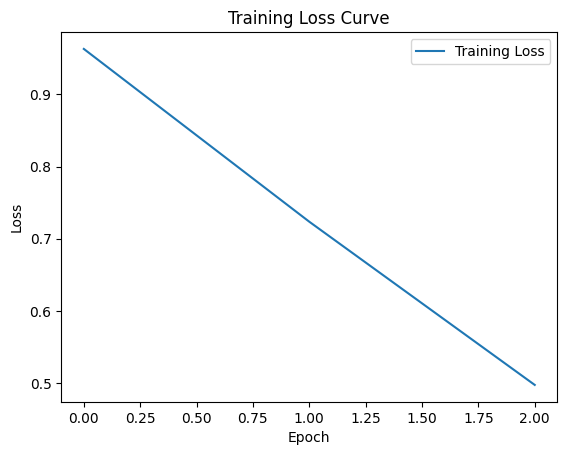

[I 2024-03-12 21:08:38,645] Trial 1 finished with value: 0.9703125 and parameters: {'learning_rate': 3.6158065512630214e-05, 'batch_size': 32}. Best is trial 1 with value: 0.9703125.


Epoch 1: Loss = 0.37101
Epoch 2: Loss = 0.22394
Epoch 3: Loss = 0.15269
Validation Accuracy: 0.9953125


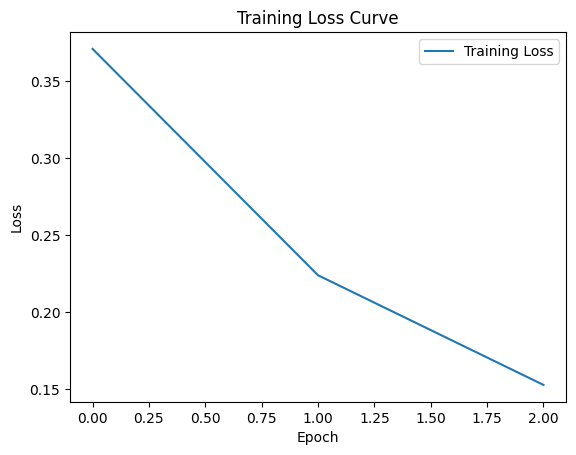

[I 2024-03-12 21:26:02,364] Trial 2 finished with value: 0.9953125 and parameters: {'learning_rate': 3.5891411172292854e-05, 'batch_size': 32}. Best is trial 2 with value: 0.9953125.


Best Hyperparameters: {'learning_rate': 3.5891411172292854e-05, 'batch_size': 32}


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# BERT model
model = AutoModelForSequenceClassification.from_pretrained(
    'nlpaueb/bert-base-greek-uncased-v1',
#     'EftychiaKarav/DistilGREEK-BERT',
    num_labels=len(label_encoder.classes_)
)
model.to(device)

def evaluate_model(model, train_loader_val):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for batch in train_loader_val:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Optuna
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    global model
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    epoch_losses = [] 
    EPOCH = 3     # REDUCED TO SUBMIT 
    model.train()
    for epoch in range(EPOCH):
        epoch_loss = 0
        for batch in train_loader:
            # Move batch to device
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch
            model.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        epoch_loss /= len(train_loader)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.5f}")

    accuracy = evaluate_model(model, train_loader)
    print(f'Validation Accuracy: {accuracy}')
    plot_loss_curve(epoch_losses)  
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)     # REDUCED TO SUBMIT 

best_params = study.best_params
print("Best Hyperparameters:", best_params)

Epoch 1: Loss = 0.11319
Epoch 2: Loss = 0.08275
Epoch 3: Loss = 0.10175
Validation Accuracy: 0.99375


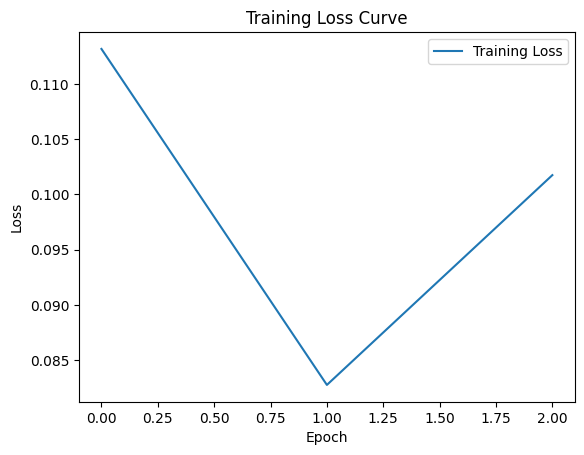

In [6]:
best_learning_rate = study.best_trial.params['learning_rate']
best_batch_size = study.best_trial.params['batch_size']
    
optimizer = AdamW(model.parameters(), lr=best_learning_rate)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)

epoch_losses = [] 
EPOCH = 3     # REDUCED TO SUBMIT 
model.train()
for epoch in range(EPOCH):
    epoch_loss = 0
    for batch in train_loader:
        # Move batch to device
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch
        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    epoch_loss /= len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.5f}")

accuracy = evaluate_model(model, train_loader)
print(f'Validation Accuracy: {accuracy}')
plot_loss_curve(epoch_losses)  

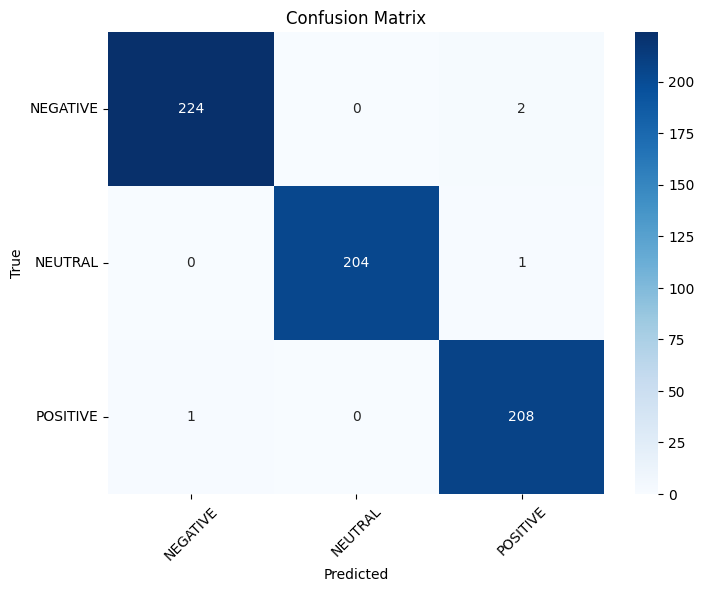

Validation Accuracy: 0.9937500000
Classification Report (Validation Dataset):
              precision    recall  f1-score   support

    NEGATIVE       1.00      0.99      0.99       226
     NEUTRAL       1.00      1.00      1.00       205
    POSITIVE       0.99      1.00      0.99       209

    accuracy                           0.99       640
   macro avg       0.99      0.99      0.99       640
weighted avg       0.99      0.99      0.99       640



In [7]:
model.eval() 
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        
        all_true_labels.extend(labels.cpu().numpy())
        all_pred_labels.extend(preds.cpu().numpy())

# Convert labels back to original
all_true_labels = label_encoder.inverse_transform(all_true_labels)
all_pred_labels = label_encoder.inverse_transform(all_pred_labels)

plot_confusion_matrix(all_true_labels, all_pred_labels, class_names=label_encoder.classes_)

class_names = label_encoder.classes_
classification_report_str = classification_report(all_true_labels, all_pred_labels, target_names=class_names)

validation_accuracy = np.mean(np.array(all_true_labels) == np.array(all_pred_labels))

print(f"Validation Accuracy: {validation_accuracy:.10f}")
print("Classification Report (Validation Dataset):")
print(classification_report_str)

In [8]:
val_encodings = tokenizer(df_valid_csv['Text'].tolist(), truncation=True, padding=True, return_tensors="pt")

val_labels_encoded = label_encoder.transform(df_valid_csv['Sentiment'])
val_labels_tensor = torch.tensor(val_labels_encoded)

val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)  # best_batch_size from Optuna

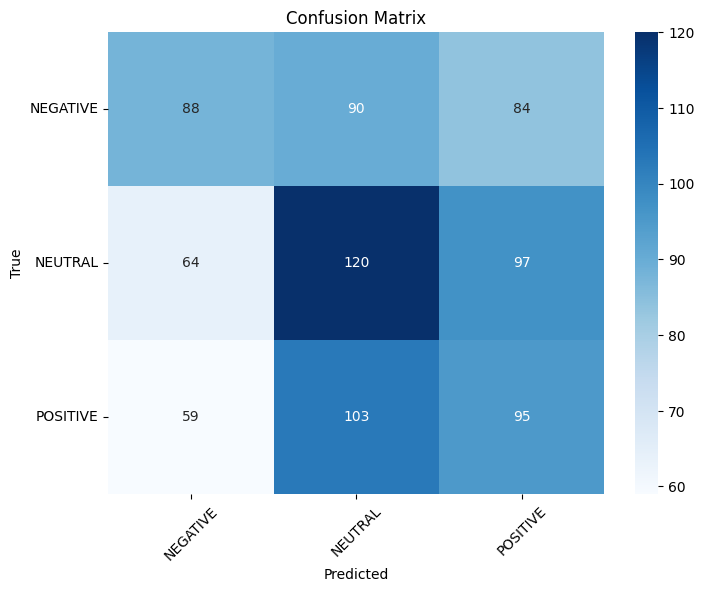

Validation Accuracy: 0.3787500000
Classification Report (Validation Dataset):
              precision    recall  f1-score   support

    NEGATIVE       0.42      0.34      0.37       262
     NEUTRAL       0.38      0.43      0.40       281
    POSITIVE       0.34      0.37      0.36       257

    accuracy                           0.38       800
   macro avg       0.38      0.38      0.38       800
weighted avg       0.38      0.38      0.38       800



In [9]:
model.eval()
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        
        all_true_labels.extend(labels.cpu().numpy())
        all_pred_labels.extend(preds.cpu().numpy())

# Convert labels back to original
all_true_labels = label_encoder.inverse_transform(all_true_labels)
all_pred_labels = label_encoder.inverse_transform(all_pred_labels)

plot_confusion_matrix(all_true_labels, all_pred_labels, class_names=label_encoder.classes_)

class_names = label_encoder.classes_
classification_report_str = classification_report(all_true_labels, all_pred_labels, target_names=class_names)

validation_accuracy = np.mean(np.array(all_true_labels) == np.array(all_pred_labels))

print(f"Validation Accuracy: {validation_accuracy:.10f}")
print("Classification Report (Validation Dataset):")
print(classification_report_str)

In [10]:
test_encodings = tokenizer(df_test_csv['Text'].tolist(), truncation=True, padding=True, return_tensors="pt")

X_test_tensor = test_encodings['input_ids']
attention_mask_test = test_encodings['attention_mask']

In [11]:
def predict_in_chunks(model, input_ids, attention_mask, chunk_size=32):
    model.eval()
    num_examples = input_ids.size(0)
    all_predictions = torch.LongTensor()

    for i in range(0, num_examples, chunk_size):
        input_ids_chunk = input_ids[i:i+chunk_size].to(device)
        attention_mask_chunk = attention_mask[i:i+chunk_size].to(device)
        with torch.no_grad():
            outputs = model(input_ids_chunk, attention_mask=attention_mask_chunk)
        _, predictions_chunk = torch.max(outputs.logits, dim=1)
        all_predictions = torch.cat((all_predictions, predictions_chunk.cpu()))

    return all_predictions


In [12]:
reduced_batch_size = best_batch_size // 2   # Reduced size for memory allocation problems
y_test_csv_pred = predict_in_chunks(model, X_test_tensor, attention_mask_test, chunk_size=reduced_batch_size)

predicted_sentiments = label_encoder.inverse_transform(y_test_csv_pred.numpy())

df_id = pd.DataFrame({'Id': df_test_csv['New_ID']})
df_pred = pd.DataFrame({'Predicted': predicted_sentiments})
df_pred_final = pd.concat([df_id, df_pred], axis=1)

# csv_file_name = 'submission.csv'
# df_pred_final.to_csv(csv_file_name, index=False)

In [13]:
# For reduced dataset i need to fill the rest of the CSV rows to submit
# Number of rows to fill with "NEUTRAL"
num_rows_to_fill = 10470 - 800

if num_rows_to_fill > 0:
    remaining_ids = range(801, 801 + num_rows_to_fill)
    remaining_preds = ['NEUTRAL'] * num_rows_to_fill
    
    df_remaining = pd.DataFrame({
        'Id': remaining_ids,
        'Predicted': remaining_preds
    })
    
    df_final_submission = pd.concat([df_pred_final, df_remaining], ignore_index=True)
else:
    df_final_submission = df_pred_final

# Save to CSV
csv_file_name = 'submission.csv'
df_final_submission.to_csv(csv_file_name, index=False)

print(f"Total rows in the final CSV: {len(df_final_submission)}")


Total rows in the final CSV: 10470
